In [54]:
import numpy as np
import xarray as xr
import statsmodels.api as sm
import intake
import glob
import pandas as pd
pd.set_option('display.max_colwidth',-1)

Load the signal and noise datasets.  Noise is the estimates of standard deviation from piControl <code>[lon x lat]</code>. Signal is the regression coefficients that relate global mean surface temperature (T<sub>global</sub>, created following Hawkins and Sutton (2012)) to local temperature (local temperature = temperature at each gridpoint).  The regression coefficients, $\alpha$ (slope) and $\beta$ (intercept), have dimensions of <code>[lon x lat]</code>.  We also need to load our T<sub>global</sub> time series. 

In [57]:
fpath_hard = '/glade/u/home/chiangf/cmip6hack-toe/notebooks/'
files_list = glob.glob(fpath_hard+'*.nc')
#print(files_list)
signal_load = xr.open_dataset(files_list[2])
#print(signal_load)
alphas = signal_load['alpha']
betas = signal_load['beta']
T_global = signal_load['smoothed_tas']
time = signal_load['time']
lat = signal_load['lat']
lon = signal_load['lon']

Now, load our gridded temperature data with <code>intake</code>.  We'll use BCC-CSM2-MR as our test case to be consistent with our earlier test analysis.  For now, we'll begin our predicts at the beginning of the scenario period (2015). 

In [66]:
data_list = pd.read_csv('/glade/u/home/molina/CMIP6_pathnames.csv')
#data_list
modelname = 'BCC-CSM2-MR'
membername = 'r1i1p1f1'
variable_id = 'tas'
#
filtereddata_list = data_list[data_list['source_id'].str.contains(modelname)]
filtereddata_list = filtereddata_list[filtereddata_list['member_id'].str.contains(membername)]

#historicalpath = filtereddata_list[filtereddata_list['experiment_id'].str.contains('historical')]['path']
scenariopath = filtereddata_list[filtereddata_list['experiment_id'].str.contains('ssp585')]['path']
#
#histpathname = data_list.loc[(data_list['source_id'] == modelname)&(data_list['member_id'] == membername)&(data_list['experiment_id'] == 'historical')]
projpathname = data_list.loc[(data_list['source_id'] == modelname)&(data_list['member_id'] == membername)&(data_list['experiment_id'] == 'ssp585')]
#
projds = xr.open_dataset(projpathname.path.values[0])
scenario_time = projds['time']
proj_temp = projds['tas']

Remove monthly means to create projected temp anomalies

In [68]:
#find the monthly climatology for each pixel
monthly_clim = proj_temp.groupby('time.month').mean()
#subtract the local monthly climatology
demonthlied_data = proj_temp.groupby('time.month') - monthly_clim

(1032, 160, 320)

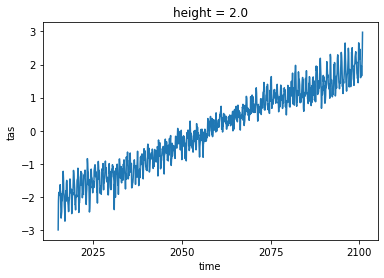

In [74]:
demonthlied_data.mean(dim=['lat','lon']).plot() #plot of global mean projected T anomalies

Okay, now that we've loaded the data, we can actually make our ToE predictions at each gridpoint.  We'll use statsmodels for this step. We want to predict our local temperature trend at each grid point--that is, how much of the local temperature trend can be explained by our global mean surface temperature trend? 

In [109]:
i = 10
j = 50
demonthlied_data_to_predict = sm.add_constant(demonthlied_data[:,i,j])
print(demonthlied_data_to_predict)
ols_model = [alphas[i,j].values,betas[i,j].values]
print(ols_model)
T_predict = ols_model.predict(demonthlied_data_to_predict)

[[ 1.         -1.94110107]
 [ 1.          1.62060547]
 [ 1.         -1.20555115]
 ...
 [ 1.          0.61483765]
 [ 1.         -1.28086853]
 [ 1.          4.70748901]]
[array(-3.27351481e-06), array(1.15682565)]


AttributeError: 'list' object has no attribute 'predict'

Now that we have our predictions, we can see that they have dimensions of <code>[lon,lat,time]</code>. We used our regression coefficients to make linear predictions of how temperature changes in time at each gridpoint.  Now, we want to know how these temperature predictions compare to internal variability--when can we say that these temperature anomalies are so extreme that they are not within the bounds of internal variability? This is the first part of our fundamental science question. <br>
<br>
We calculate a signal to noise ratio--we simply divide our local temperature predictions by our noise. Our output will have dimensions of <code>[lon x lat x time]</code>. 

So now we have a signal to noise ratio.  We are ready to estimate time of emergence.  We decide that <b> time of emergence </b> is the first year in which some signal-to-noise ratio exceeds a threshold that we set.  We estimate this first year for each gridpoint, which provides an output array with dimensions of <code>[lon x lat]</code>.  The values in the ToE array will be in units of years. 

Finally, we can plot the time of emergence as a function of gridpoint. 